In [ ]:
import re
from pathlib import Path
from pprint import pprint
from typing import Any, Dict

import pandas as pd

## Load all result files from models' benchmarking


In [2]:
# Vosk
OUT_DIR = Path("./benchmark_output/")
VOSK_DIR = OUT_DIR / "vosk"
vosk_df = pd.read_csv(VOSK_DIR / "vi_with_server.csv")
print(vosk_df.head(), "\n")

vosk_stats = {
    "model": "vosk-model-vn-0.4",
    "server": True,
    "elapsed_time": vosk_df["elapsed"].sum(),
    "rtf": vosk_df["rtf"].mean().round(decimals=4),
}
pprint(vosk_stats)

              utt  elapsed    rtf  \
0  utt_000000.wav    0.659  0.127   
1  utt_000001.wav    0.640  0.203   
2  utt_000002.wav    1.103  0.205   
3  utt_000003.wav    1.340  0.200   
4  utt_000004.wav    1.038  0.190   

                                                text  
0  hiện nay việc chỉ bằng thư không được đặt tron...  
1  mỹ cậu nhỏ lớn lên thái lưng xuống khi mặt của nó  
2  cần phù thấp nên linh lung linh và cấm sau này...  
3  bị mức chỉ có duy nhất sẽ trình giúp sức kim t...  
4  ca sĩ cái chuyện trên xe còn chỉ có minh chứng...   

{'elapsed_time': np.float64(88.063),
 'model': 'vosk-model-vn-0.4',
 'rtf': np.float64(0.167),
 'server': True}


In [ ]:
# Sherpa-onnx
SHERPA_DIR = OUT_DIR / "sherpa-onnx"
sherpa_vi_df = pd.read_csv(SHERPA_DIR / "vi_hypothesis.csv")
sherpa_vi_df["utt"] = sherpa_vi_df["wav"].apply(lambda x: x.split("/")[-1])
sherpa_vi_df = sherpa_vi_df.drop(columns=["wav"])

sherpa_vi_int8_df = pd.read_csv(SHERPA_DIR / "vi_int8_hypothesis.csv")
sherpa_vi_int8_df["utt"] = sherpa_vi_int8_df["wav"].apply(lambda x: x.split("/")[-1])
sherpa_vi_int8_df = sherpa_vi_int8_df.drop(columns=["wav"])


def parse_sherpa_stats(path: Path | str) -> Dict[str, float]:
    stats = dict()
    with open(path) as f:
        for line in f:
            line = line.strip()

            # Num-threads
            if line.startswith("num threads:"):
                stats["num_threads"] = int(line.split(":")[1].strip())

            # Decoding method
            elif line.startswith("decoding method:"):
                stats["decoding_method"] = line.split(":")[1].strip()

            # Elapsed (s)
            elif line.startswith("Elapsed seconds:"):
                stats["elapsed_seconds"] = float(re.search(r"([\d.]+)", line).group(1))

            # RTF & duration (s)
            elif line.startswith("Real time factor"):
                m = re.search(r"([\d.]+)\s*/\s*([\d.]+)\s*=\s*([\d.]+)", line)
                if m:
                    stats["audio_duration"] = float(m.group(2))
                    stats["rtf"] = float(m.group(3))
    return stats


sherpa_vi_stats = {
    "model": "zipformer-vi-2025-04-20",
    "precision": "fp32",
    **parse_sherpa_stats(SHERPA_DIR / "vi_stats.txt"),
}
sherpa_vi_int8_stats = {
    "model": "zipformer-vi-2025-04-20",
    "precision": "int8",
    **parse_sherpa_stats(SHERPA_DIR / "vi_int8_stats.txt"),
}

print(sherpa_vi_df.head())
print(sherpa_vi_int8_df.head(), "\n")
pprint(sherpa_vi_stats)
pprint(sherpa_vi_int8_stats)

                                                text             utt
0   HIỆN NAY VỊ TRÍ CỦA BÀN THỜ THƯỜNG ĐƯỢC ĐẶT T...  utt_000000.wav
1   ĐỂ CẬU NHỎ HƯỚNG LÊN HAI HƯỚNG XUỐNG KHI MẶC ...  utt_000001.wav
2   CẢ PHỐ THẮP ĐÈN LỒNG LUNG LINH VÀ CẢM GIÁC Ở ...  utt_000002.wav
3   ĐÂY LÀ MỨC CHI PHÍ CÓ LÝ NHẤT DỰA TRÊN KỸ THU...  utt_000003.wav
4   CA SĨ THÁI THÙY LINH CHIA SẺ CON CHỊ KHÔNG MẮ...  utt_000004.wav
                                                text             utt
0   HIỆN NAY VỊ TRÍ CỦA BÀN THỜ THƯỜNG ĐƯỢC ĐẶT T...  utt_000000.wav
1   ĐỂ CẬU NHỎ HƯỚNG LÊN HAI HƯỚNG XUỐNG KHI MẶC ...  utt_000001.wav
2   CẢ PHỐ THẮP ĐÈN LỒNG LUNG LINH VÀ CẢM GIÁC Ở ...  utt_000002.wav
3   ĐÂY LÀ MỨC CHI PHÍ CÓ LÝ NHẤT DỰA TRÊN KỸ THU...  utt_000003.wav
4   CA SĨ THÁI THÙY LINH CHIA SẺ CON CHỊ KHÔNG MẮ...  utt_000004.wav 

{'audio_duration': 522.545,
 'decoding_method': 'greedy_search',
 'elapsed_seconds': 50.335,
 'model': 'zipformer-vi-2025-04-20',
 'num_threads': 12,
 'precision': 'fp32'

## Calc WER


In [4]:
# Load the reference
ref_df = pd.read_csv("./data/metadata.csv")
ref_df = ref_df.drop(columns=["wav_path", "duration"])
ref_df = ref_df.rename(columns={"utt_id": "utt"})
print(ref_df.head())

          utt                                               text
0  utt_000000  hiện nay vị trí của bàn thờ thường được đặt tr...
1  utt_000001  để cậu nhỏ hướng lên hay hướng xuống khi mặc q...
2  utt_000002  cả phố thắp đèn lồng lung linh và cảm giác ở n...
3  utt_000003  đây là mức chi phí có lí nhất dựa trên kỹ thuậ...
4  utt_000004  ca sĩ thái thùy linh chia sẻ con chị không mắc...


In [ ]:
import jiwer
from jiwer import (
    Compose,
    ReduceToListOfListOfWords,
    RemoveMultipleSpaces,
    Strip,
    ToLowerCase,
)


def compute_error(refs: pd.Series, hypos: pd.Series, stats: Dict[str, Any]):
    """
    Compute Word Error Rate (WER) between reference and hypothesis texts.

    Args:
        refs  (pd.Series): ground-truth transcripts
        hypos (pd.Series): ASR outputs

    Returns:
        float: WER (0.0 ~ 1.0)
    """
    assert len(refs) == len(hypos), "refs and hypos must have the same length"

    # Text normalization (VERY important)
    transform = Compose(
        [
            ToLowerCase(),
            Strip(),
            RemoveMultipleSpaces(),
            ReduceToListOfListOfWords(),
        ]
    )

    refs = refs.fillna("").astype(str).tolist()
    hypos = hypos.fillna("").astype(str).tolist()

    outputs = jiwer.process_words(
        reference=refs,
        hypothesis=hypos,
        reference_transform=transform,
        hypothesis_transform=transform,
    )

    wer = outputs.wer
    wil = outputs.wil
    mer = outputs.mer

    cer = jiwer.cer(
        reference=refs,
        hypothesis=hypos,
        reference_transform=transform,
        hypothesis_transform=transform,
    )
    stats.update(
        {
            "wer": wer,
            "wil": wil,
            "mer": mer,
            "cer": cer,
        }
    )

    return stats, wer, wil, mer, cer

In [6]:
[
    compute_error(hypos=df["text"], refs=ref_df["text"], stats=stat)
    for df, stat in zip(
        [vosk_df, sherpa_vi_df, sherpa_vi_int8_df],
        [vosk_stats, sherpa_vi_stats, sherpa_vi_int8_stats],
    )
]

pprint(vosk_stats)
pprint(sherpa_vi_stats)
pprint(sherpa_vi_int8_stats)

{'cer': 0.4638971315529179,
 'elapsed_time': np.float64(88.063),
 'mer': 0.4632098765432099,
 'model': 'vosk-model-vn-0.4',
 'rtf': np.float64(0.167),
 'server': True,
 'wer': 0.4638971315529179,
 'wil': 0.6943741748713937}
{'audio_duration': 522.545,
 'cer': 0.025717111770524232,
 'decoding_method': 'greedy_search',
 'elapsed_seconds': 50.335,
 'mer': 0.02567901234567901,
 'model': 'zipformer-vi-2025-04-20',
 'num_threads': 12,
 'precision': 'fp32',
 'rtf': 0.096,
 'wer': 0.025717111770524232,
 'wil': 0.04267158718049746}
{'audio_duration': 522.545,
 'cer': 0.024727992087042534,
 'decoding_method': 'greedy_search',
 'elapsed_seconds': 32.069,
 'mer': 0.024679170779861797,
 'model': 'zipformer-vi-2025-04-20',
 'num_threads': 12,
 'precision': 'int8',
 'rtf': 0.061,
 'wer': 0.024727992087042534,
 'wil': 0.04118843663102112}


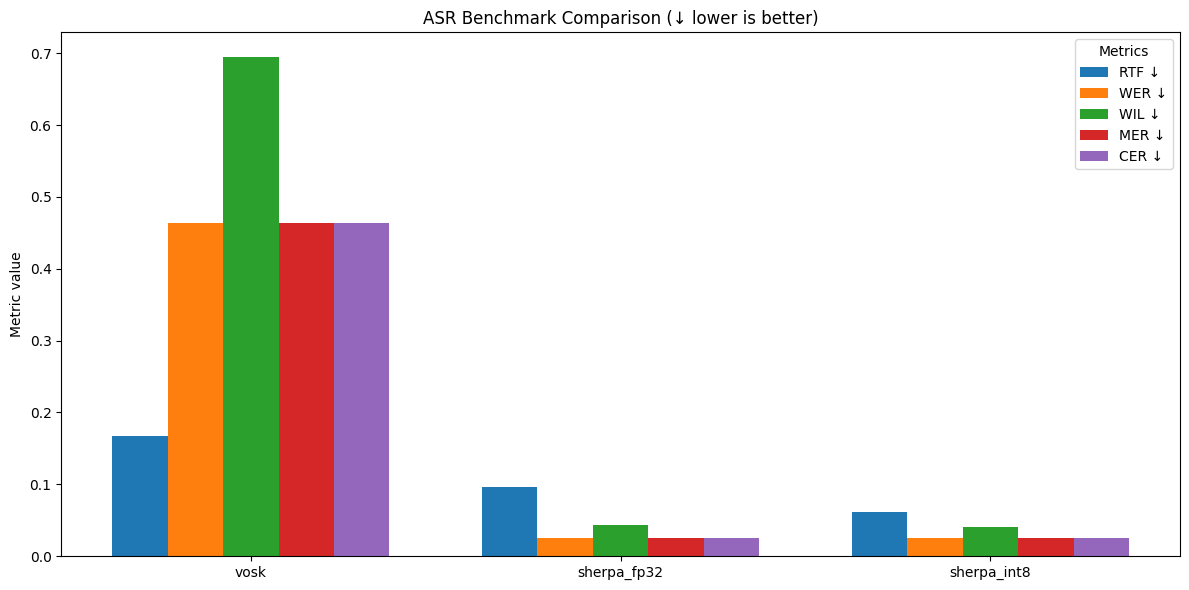

In [ ]:
import matplotlib.pyplot as plt

stats = [vosk_stats, sherpa_vi_stats, sherpa_vi_int8_stats]
metrics = ["rtf", "wer", "wil", "mer", "cer"]
models = ["vosk", "sherpa_fp32", "sherpa_int8"]

scores = {metric: [s[metric] for s in stats] for metric in metrics}

x = range(len(models))
width = 0.15

plt.figure(figsize=(12, 6))

plt.bar([i - 2 * width for i in x], scores["rtf"], width, label="RTF ↓")
plt.bar([i - width for i in x], scores["wer"], width, label="WER ↓")
plt.bar(x, scores["wil"], width, label="WIL ↓")
plt.bar([i + width for i in x], scores["mer"], width, label="MER ↓")
plt.bar([i + 2 * width for i in x], scores["cer"], width, label="CER ↓")

plt.xticks(x, models)
plt.ylabel("Metric value")
plt.title("ASR Benchmark Comparison (↓ lower is better)")
plt.legend(title="Metrics")

plt.tight_layout()
plt.show()